
<H1>Asset Allocation</H1>

Summary:
Analyzing risk performance identifies opportunities for upsell in order to meet the needs of our investors, faster. With risk tolerance levels ranging from Conservative to Balanced to Moderately Aggressive to Aggressive, here's the info you need to know about how our varying risk portfolios have done in the past, whether or not they've performed as expected, and whether or not reallocation is necessary to maximize the returns of each risk model moving forward.

Findings: Out of all underlying assets, Notes has the worst performance given the amount of risk. Re-allocation is necessary for maximum risk/return results. After all analysis was conducted, here is a template for how portfolios in different risk groups should be conducted:

All model allocations are comprised of some combination of the following base strategies depending on the desired amount of risk. Some models have been slightly modified due to inaccessibility to some data, but nevertheless accurately portray their historic returns.

percent returns dataframe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import datetime
import seaborn as sns
import statsmodels
from arch import arch_model
from arch.univariate import GARCH
import pysolnp
import warnings
import math
import statistics
warnings.simplefilter(action='ignore', category=FutureWarning)

#print note data
notes = pd.read_csv("PerformanceExport_Account10112_Adams.csv")
#print model returns data
model_returns = pd.read_csv("model_returns (2).csv")

#import defined investment fund
defined_invest = pd.read_csv("defined (1).csv")

#import model returns with defined investment
returns_w_fund = pd.read_csv("model_returns_with_fund2.csv")

#import fairway
fairway = pd.read_csv("fairway.csv")

defined = returns_w_fund.iloc[:, -2:].dropna()
defined = defined.rename(columns={'Unnamed: 9':'date'})
defined.loc[:,'date'] = defined.loc[:,'date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').date())
defined = defined.set_index('date')

model_returns

,Unnamed: 0,CapPres,Balanced,ProGrowth,AggressiveGrowth,DividendEquity,OppEquity
0,2020-04-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-04-23,-0.000144,0.000798,0.000856,0.001074,-0.003560,0.015128
2,2020-04-24,0.005554,0.011574,0.012905,0.013769,0.004858,0.026373
3,2020-04-27,0.010831,0.027225,0.031377,0.034042,0.027241,0.051669
4,2020-04-28,0.009703,0.025697,0.029375,0.032522,0.046650,0.060620
...,...,...,...,...,...,...,...
562,2022-07-15,0.098417,0.261118,0.328053,0.394141,0.627252,0.971907
563,2022-07-18,0.095882,0.255405,0.320411,0.384665,0.620293,0.971275
564,2022-07-19,0.103310,0.277939,0.351587,0.425092,0.652703,1.025503
565,2022-07-20,0.105199,0.284747,0.361856,0.439561,0.650963,1.055445


In [2]:
model_returns = model_returns.rename(columns={'Unnamed: 0':'date'})
model_returns.loc[:,'date'] = model_returns.loc[:,'date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())
model_returns = model_returns.set_index('date')
model_returns=model_returns.dropna()

In [3]:
# fairway = pd.read_csv("fairway.csv")
# fairway_ret = fairway.loc[:, ['Date', 'Ret']]
# fairway_ret = fairway_ret.rename(columns={'Date':'date', 'Ret': 'fairway'})
# fairway_ret.loc[:,'date'] = fairway_ret.loc[:,'date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').date())
# fairway_ret.loc[:,'fairway'] = fairway_ret.loc[:,'fairway'].apply(lambda x: float(x[:-1]))
# fairway_ret = fairway_ret.set_index('date')


In [4]:
notes_ret = notes.loc[:, ['As Of Date', 'Factor - Notes']]
notes_ret = notes_ret.rename(columns={'As Of Date':'date', 'Factor - Notes': 'Notes'})
notes_ret.loc[:, 'Notes'] = notes_ret.loc[:, 'Notes']/notes_ret.loc[:, 'Notes'].shift(1) - 1
notes_ret.loc[:,'date'] = notes_ret.loc[:,'date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date())
notes_ret = notes_ret.set_index('date')
model_returns.loc[:, 'Notes'] = notes_ret['Notes']
#model_returns.loc[:, "fairway"] = fairway_ret.loc[model_returns.index]/100
model_returns.loc[:, "Defined"] = defined['Defined']
#calculating daily percent change
model_returns.iloc[:,:-2] = (1+model_returns.iloc[:,:-2])/(1+model_returns.iloc[:, :-2].shift(1)) - 1


In [5]:
model_returns.loc[:,'Defined']/=100
#model_returns.query("Defined>.06 or Defined<-.06")

In [6]:
outliers = model_returns.query("Defined>.06 or Defined<-.06").index
model_returns.drop(outliers).head()
model_returns.dropna()

,CapPres,Balanced,ProGrowth,AggressiveGrowth,DividendEquity,OppEquity,Notes,Defined
date,,,,,,,,
2020-04-23,-0.000144,0.000798,0.000856,0.001074,-0.003560,0.015128,-0.017250,-0.000012
2020-04-24,0.005698,0.010767,0.012039,0.012682,0.008448,0.011077,0.007298,0.005673
2020-04-27,0.005248,0.015472,0.018236,0.019998,0.022275,0.024647,0.013187,0.014750
2020-04-28,-0.001115,-0.001488,-0.001941,-0.001470,0.018895,0.008511,0.003752,0.021568
2020-04-29,0.013061,0.024741,0.028436,0.030551,0.033757,0.054543,-0.003541,0.023731
...,...,...,...,...,...,...,...,...
2022-07-14,-0.003056,-0.002460,-0.001985,-0.001278,-0.004268,-0.012834,0.022371,-0.006167
2022-07-15,0.007355,0.012999,0.016126,0.019031,0.014852,0.020649,-0.002676,-5.235200
2022-07-18,-0.002308,-0.004530,-0.005754,-0.006797,-0.004276,-0.000320,0.008110,1.240567


In [7]:
model_returns.loc[outliers, "Defined"] = model_returns.loc[outliers, "AggressiveGrowth"]

Portfolio allocations and lists

In [8]:
#model returns conservative

model_returns.loc[:,'cons_std_model20'] = model_returns.loc[:,"CapPres"]
model_returns.loc[:,'cons_std_model100'] = model_returns["CapPres"]
model_returns.loc[:,'cons_std_model1000'] = model_returns['CapPres']*.90 + model_returns['Notes']*.10
model_returns.loc[:,"cons_std_model500"] = model_returns["CapPres"]
model_returns.loc[:,'cons_income100'] = model_returns['CapPres']
model_returns.loc[:,'cons_income200'] = model_returns['CapPres']
model_returns.loc[:,"cons_income1000"] = model_returns["CapPres"]*.90 + model_returns['Notes']*.10

#model returns balanced

model_returns.loc[:,'balanced_Notes200'] = model_returns['CapPres']*.60 + model_returns["Notes"]*.40
model_returns.loc[:,'balanced_Notes500'] = model_returns['CapPres']*.50 + model_returns['Notes']*.40 + model_returns['OppEquity']*.10
model_returns.loc[:,'balanced_Notes1000'] = model_returns['Notes']*.30 + model_returns['CapPres']*.50 + model_returns['OppEquity']*.10 + model_returns['Defined']*.10
model_returns.loc[:,'balanced_income100'] = model_returns['CapPres']*.60 + model_returns['Notes']*.10 + model_returns['DividendEquity']*.30
model_returns.loc[:,'balanced_income200'] = model_returns['CapPres']*.60 + model_returns['Balanced']*.40
model_returns.loc[:,'balanced_income1000'] = model_returns['CapPres']*.40 + model_returns['Balanced']*.40 + model_returns["Defined"]*.20
model_returns.loc[:,'balanced_std_model1000'] = model_returns['CapPres']*.30 + model_returns["Balanced"]*.50 + model_returns['Defined']*.20
model_returns.loc[:,'balanced_std_model500'] = model_returns['CapPres']*.20 + model_returns["Balanced"]*.60 + model_returns['Notes']*.20
model_returns.loc[:,'balanced_std_model100'] = model_returns['CapPres']*.20 + model_returns["Balanced"]*.70 + model_returns['Notes']*.10
model_returns.loc[:,'balanced_std_model20'] = model_returns["Balanced"]

#model returns moderately aggressive
model_returns.loc[:,'moderate_std_model20'] = model_returns["ProGrowth"]
model_returns.loc[:,'moderate_std_model100'] = model_returns['CapPres']*.20 + model_returns["ProGrowth"]*.60 + model_returns['Notes']*.20
model_returns.loc[:,'moderate_std_model500'] = model_returns['CapPres']*.10 + model_returns["ProGrowth"]*.60 + model_returns['Notes']*.20
+ model_returns["OppEquity"]*.10
model_returns.loc[:,'moderate_std_model1000'] = model_returns['CapPres']*.10 + model_returns['ProGrowth']*.80 + model_returns["OppEquity"]*.10
model_returns.loc[:,'moderate_Notes200'] = model_returns['CapPres']*.25 + model_returns['ProGrowth']*.25 + model_returns["Notes"]*.50
model_returns.loc[:,'moderate_Notes500'] = model_returns['Balanced']*.40 + model_returns['Notes']*.50 + model_returns['OppEquity']*.10
model_returns.loc[:,'moderate_Notes1000'] = model_returns['Balanced']*.40 + model_returns['Notes']*.40 + model_returns["OppEquity"]*.10 + model_returns["Defined"]*.10
model_returns.loc[:,"moderate_agg100"] = model_returns["ProGrowth"]*.70 + model_returns["Notes"]*.3
model_returns.loc[:,'moderate_agg200'] = model_returns['Balanced']*.50 + model_returns['Notes']*.10 + model_returns['DividendEquity']*.40
model_returns.loc[:,'moderate_agg1000'] = model_returns['CapPres']*.10 + model_returns['ProGrowth']*.60 + model_returns['DividendEquity']*.10 + model_returns["Defined"]*.20
moderate_agg_list = ['moderate_std_model20','moderate_std_model100','moderate_std_model500','moderate_std_model1000','moderate_Notes200', 'moderate_Notes500','moderate_Notes1000','moderate_agg100','moderate_agg200','moderate_agg1000']

#model returns aggressive
model_returns.loc[:,"agg_income100"] = model_returns["AggressiveGrowth"]*.70 + model_returns["Notes"]*.3
model_returns.loc[:,'agg_income200'] = model_returns['AggressiveGrowth']*.50 + model_returns['Notes']*.10 + model_returns['DividendEquity']*.40
model_returns.loc[:,'agg_income1000'] = model_returns['AggressiveGrowth']*.70 + model_returns['DividendEquity']*.30
model_returns.loc[:,'agg_Notes200'] = model_returns['AggressiveGrowth']*.50 + model_returns['Notes']*.50
model_returns.loc[:,'agg_Notes500'] = model_returns['AggressiveGrowth']*.40 + model_returns['Notes']*.50 + model_returns['OppEquity']*.10
model_returns.loc[:,'agg_Notes1000'] = model_returns['AggressiveGrowth']*.50 + model_returns['OppEquity']*.10 + model_returns["Defined"]*.40
model_returns.loc[:,'agg_std_model20'] = model_returns["AggressiveGrowth"]
model_returns.loc[:,'agg_std_model100'] = model_returns['AggressiveGrowth']*.80 + model_returns["Notes"]*.20
model_returns.loc[:,'agg_std_model500'] = model_returns['AggressiveGrowth']*.60 + model_returns["Notes"]*.20 + model_returns['OppEquity']*.20
model_returns.loc[:,'agg_std_model1000'] = model_returns['AggressiveGrowth']*.70 + model_returns["OppEquity"]*.10 + model_returns['Defined']*.20

model_returns = model_returns.dropna()
model_returns

,CapPres,Balanced,ProGrowth,AggressiveGrowth,DividendEquity,OppEquity,Notes,Defined,cons_std_model20,cons_std_model100,...,agg_income100,agg_income200,agg_income1000,agg_Notes200,agg_Notes500,agg_Notes1000,agg_std_model20,agg_std_model100,agg_std_model500,agg_std_model1000
date,,,,,,,,,,,,,,,,,,,,,
2020-04-23,-0.000144,0.000798,0.000856,0.001074,-0.003560,0.015128,-0.017250,-0.000012,-0.000144,-0.000144,...,-0.004423,-0.002612,-0.000317,-0.008088,-0.006683,0.002045,0.001074,-0.002591,0.000220,0.002262
2020-04-24,0.005698,0.010767,0.012039,0.012682,0.008448,0.011077,0.007298,0.005673,0.005698,0.005698,...,0.011067,0.010450,0.011411,0.009990,0.009829,0.009718,0.012682,0.011605,0.011284,0.011119
2020-04-27,0.005248,0.015472,0.018236,0.019998,0.022275,0.024647,0.013187,0.014750,0.005248,0.005248,...,0.017954,0.020228,0.020681,0.016592,0.017057,0.018364,0.019998,0.018636,0.019565,0.019413
2020-04-28,-0.001115,-0.001488,-0.001941,-0.001470,0.018895,0.008511,0.003752,0.021568,-0.001115,-0.001115,...,0.000097,0.007198,0.004639,0.001141,0.002139,0.008743,-0.001470,-0.000426,0.001571,0.004136
2020-04-29,0.013061,0.024741,0.028436,0.030551,0.033757,0.054543,-0.003541,0.023731,0.013061,0.013061,...,0.020324,0.028424,0.031513,0.013505,0.015905,0.030222,0.030551,0.023733,0.028531,0.031586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-14,-0.003056,-0.002460,-0.001985,-0.001278,-0.004268,-0.012834,0.022371,-0.006167,-0.003056,-0.003056,...,0.005817,-0.000109,-0.002175,0.010547,0.009391,-0.004389,-0.001278,0.003452,0.001141,-0.003412
2022-07-15,0.007355,0.012999,0.016126,0.019031,0.014852,0.020649,-0.002676,0.019031,0.007355,0.007355,...,0.012519,0.015189,0.017778,0.008178,0.008340,0.019193,0.019031,0.014690,0.015013,0.019193
2022-07-18,-0.002308,-0.004530,-0.005754,-0.006797,-0.004276,-0.000320,0.008110,-0.006797,-0.002308,-0.002308,...,-0.002325,-0.004298,-0.006041,0.000657,0.001304,-0.006149,-0.006797,-0.003815,-0.002520,-0.006149


In [9]:
model_returns.to_pickle('model_returns2.pkl')

In [10]:
(1+model_returns.loc[:,"Notes"]).prod()**(252/565)-1

0.02346589194949633

In [11]:
model_returns["AggressiveGrowth"]

date
2020-04-23    0.001074
2020-04-24    0.012682
2020-04-27    0.019998
2020-04-28   -0.001470
2020-04-29    0.030551
                ...   
2022-07-14   -0.001278
2022-07-15    0.019031
2022-07-18   -0.006797
2022-07-19    0.029196
2022-07-20    0.010153
Name: AggressiveGrowth, Length: 565, dtype: float64

_____________________________________________________________________________________________________________________________

Sharpe Ratio Dataframe

In [12]:
cov = model_returns.iloc[:,:8].cov().values
mean_returns = [((1+model_returns.iloc[:, i]).prod()**(252/model_returns.shape[0])).item()-1 for i in range(8)]
vol = [(model_returns.iloc[:, i]).std()*np.sqrt(252).item() for i in range(8)]

In [13]:
underlying_ports = pd.DataFrame(index=model_returns.columns[:8], columns=['Return', 'Vol', 'Sharpe'])
underlying_ports.loc[:,'Return'] = mean_returns
underlying_ports.loc[:, 'Vol'] = vol
underlying_ports.loc[:,'Sharpe'] = underlying_ports.loc[:,'Return']/underlying_ports.loc[:, 'Vol']



As shown in the dataframe above, the two underlying assets with the highest risk/return ratio are DividendEquity and OppEquity, with a 1.46 and a 1.52 ratio respectively. Although this is helpful in explaining performance of our individual portfolios, the past 3 years have been an abnormally high-performing period for large-cap US equity, and therefore does not project long-term of US large cap equity.

Closely behind these two high-performing stocks is the Defined Investment fund, which has a high sharp ratio as well. We have confidence that the Defined Investment Fund will be one of the most risk-efficient assets as it is constructed and actively hedged to drive risk-efficient returns.

We classified days that had greater than a 6% return or less than a -6% return as outliers in the Defined Investment fund. We extracted them from the data, and then checked for correlation. The correlations between funds looked as expected, indicating to us that the data was successfully wrangled and ready to be used for analysis.

___________________________________________________________________________________________________________________________

In [14]:
model_returns.to_csv("model_returns.csv")

Dataframe for annualized returns, standard deviation, sharpe ratio and risk group

In [15]:
class PortGroup:
    def plot_correlation(self):
        sns.heatmap(self.returns_data.corr())
    
    def plot_cumulative_returns(self):
        data = (1+self.returns_data).cumprod()
        return data.plot()
        
    def __init__(self, mr=None, ports=None, rf_rate=0):
        self.mean_variance = pd.DataFrame(index=ports, columns=['Annualized Returns', 'Standard Deviation', 'Sharpe'])
        self.mean_variance.loc[:, 'Annualized Returns'] = (1+mr.loc[:,ports]).prod()**(252/len(mr.index))-1
        self.mean_variance.loc[:,'Standard Deviation'] = mr.loc[:,ports].std()*np.sqrt(252)
        self.mean_variance.loc[:, 'Sharpe'] = \
            (self.mean_variance.loc[:, 'Annualized Returns'] - rf_rate)/self.mean_variance.loc[:,'Standard Deviation']
        self.returns_data = mr.loc[:,ports]


In [16]:
# Model Lists
cons_list = ["cons_std_model20", "cons_std_model100", "cons_std_model1000", 'cons_std_model500', "cons_income1000", 'cons_income100', 'cons_income200']
balanced_list = ['balanced_Notes200','balanced_Notes500','balanced_Notes1000','balanced_income100','balanced_income200', 'balanced_income1000','balanced_std_model1000','balanced_std_model500','balanced_std_model100','balanced_std_model20']
agg_list = ['agg_income100','agg_income200','agg_income1000','agg_Notes200','agg_Notes500', 'agg_Notes1000','agg_std_model20','agg_std_model100','agg_std_model500','agg_std_model1000']
moderate_agg_list = ['moderate_std_model20','moderate_std_model100','moderate_std_model500','moderate_std_model1000','moderate_Notes200', 'moderate_Notes500','moderate_Notes1000','moderate_agg100','moderate_agg200','moderate_agg1000']


#model_returns.loc[:,cons_list]
#annualized returns
(1+model_returns.loc[:,cons_list]).prod()**(252/len(model_returns.index))-1
# #standard deviation
#model_returns.loc[:,cons_list].std()*np.sqrt(252)


cons_std_model20      0.045623
cons_std_model100     0.045623
cons_std_model1000    0.044362
cons_std_model500     0.045623
cons_income1000       0.044362
cons_income100        0.045623
cons_income200        0.045623
dtype: float64

In [17]:
class PortfolioGroups:
    def __init__(self, mr, all_ports):
        self.returns_data = mr
        self.mean_variance = pd.DataFrame(columns=['Annualized Returns', 'Standard Deviation', 'Sharpe','Risk Group'])
        self.ports = {}
        for ports in all_ports.keys():
            self.ports[ports] = PortGroup(mr=mr, ports=all_ports[ports])
            tmp = self.ports[ports].mean_variance
            tmp['Risk Group'] = ports
            self.mean_variance = pd.concat([self.mean_variance, tmp])
            
        

In [18]:
model_portfolios = PortfolioGroups(mr=model_returns, all_ports={'Conservative':cons_list, 
                                                                'Balanced':balanced_list, 
                                                                'Moderate Aggressive':moderate_agg_list, 
                                                                'Aggressive':agg_list})

#model_portfolios.mean_variance.head(4)
#model_portfolios.mean_variance.loc[model_portfolios.mean_variance["Risk Group"] == "Conservative"]

____________________________________________________________________________________________________________________________

Getting efficient frontier

In [19]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(np.atleast_2d(mean_returns)*weights.T)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        if i  < len(mean_returns):
            weights = np.atleast_2d(np.zeros((len(mean_returns)))).T
            weights[i,0] = 1
        else:
            weights = np.atleast_2d(np.random.random(len(mean_returns))).T
            weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record



In [20]:
random_portfolios(num_portfolios=1, mean_returns=mean_returns, cov_matrix=cov, risk_free_rate=0.01)

cov = model_returns.iloc[:,:8].cov().values
mean_returns = [((1+model_returns.iloc[:, i]).prod()**(252/model_returns.shape[0])).item()-1 for i in range(8)]
num_portfolios = 10000
risk_free_rate = 0.01
cov_matrix = cov
model_returns.iloc[:,:8].cov()

,CapPres,Balanced,ProGrowth,AggressiveGrowth,DividendEquity,OppEquity,Notes,Defined
CapPres,0.000017,0.000032,0.000039,0.000044,0.000035,0.000052,0.000026,0.000035
Balanced,0.000032,0.000068,0.000084,0.000099,0.000077,0.000116,0.000060,0.000080
ProGrowth,0.000039,0.000084,0.000105,0.000124,0.000095,0.000145,0.000077,0.000102
AggressiveGrowth,0.000044,0.000099,0.000124,0.000148,0.000112,0.000172,0.000092,0.000122
DividendEquity,0.000035,0.000077,0.000095,0.000112,0.000120,0.000148,0.000071,0.000094
OppEquity,0.000052,0.000116,0.000145,0.000172,0.000148,0.000237,0.000113,0.000148
Notes,0.000026,0.000060,0.000077,0.000092,0.000071,0.000113,0.000118,0.000084
Defined,0.000035,0.000080,0.000102,0.000122,0.000094,0.000148,0.000084,0.000154


In [21]:
model_returns.iloc[:,:8].corr()

,CapPres,Balanced,ProGrowth,AggressiveGrowth,DividendEquity,OppEquity,Notes,Defined
CapPres,1.000000,0.947143,0.920495,0.891569,0.789059,0.829431,0.587439,0.694740
Balanced,0.947143,1.000000,0.996183,0.985825,0.855005,0.914703,0.674156,0.784659
ProGrowth,0.920495,0.996183,1.000000,0.996134,0.849404,0.918693,0.690448,0.797844
AggressiveGrowth,0.891569,0.985825,0.996134,1.000000,0.842919,0.920372,0.701633,0.806881
DividendEquity,0.789059,0.855005,0.849404,0.842919,1.000000,0.877523,0.594992,0.688368
OppEquity,0.829431,0.914703,0.918693,0.920372,0.877523,1.000000,0.677565,0.776309
Notes,0.587439,0.674156,0.690448,0.701633,0.594992,0.677565,1.000000,0.620716
Defined,0.694740,0.784659,0.797844,0.806881,0.688368,0.776309,0.620716,1.000000


<AxesSubplot:ylabel='Frequency'>

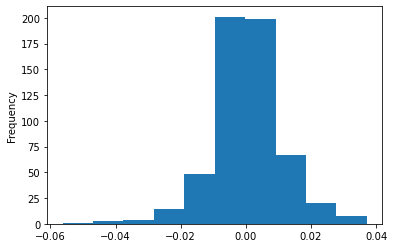

In [22]:
model_returns["Notes"].plot(kind = "hist")

In [23]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
    cmap = get_cmap(len(data))
    
    
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, func, model_portfolios):
    table = model_returns.iloc[:,:8]
    results, weights = func(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T 


    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T


    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualized Return:", round(rp,2))
    print("Annualized Volatility:", round(sdp,2))
    print("\n")
    print (max_sharpe_allocation)
    print( "-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualized Return:", round(rp_min,2))
    print( "Annualized Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)

    plt.figure(figsize=(20, 14))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    'Annualized Returns', 'Standard Deviation'

    #plt.scatter(sdcons, returnscons, data = conservative_ports,  linestyle='none', marker='D', markersize=16, markeredgecolor="orange", markeredgewidth=5)
    mps = model_portfolios.mean_variance

      #  if df.loc[x, 'ROUTE_ID'].startswith(('01', '02', '03')) is True:
    def get_cmap(n, name='hsv'):
        '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
        RGB color; the keyword argument name must be a standard mpl colormap name.'''
        return plt.cm.get_cmap(name, n)

    cmap_ports = get_cmap(len(mps))
    cmap_risk =  get_cmap(len(mps['Risk Group'].unique()))


    for ri ,risk_group in enumerate(mps['Risk Group'].unique()):
        risk_color = cmap_risk(ri)
        for pi, port in enumerate(mps.query('`Risk Group` == @risk_group').index):
            ret = mps.loc[port, 'Annualized Returns']
            std = mps.loc[port, 'Standard Deviation']
            port_color = cmap_ports(pi)
            plt.scatter(std, ret, marker='v', c=port_color, edgecolor = risk_color, linewidth = 6, s=500, label=port)


#         for i in mps.index:
#             for i in mps.loc[i,"Risk Group"] == "Conservative":
#                 plt.scatter(mps.loc[i, 'Annualized Returns'], mps.loc[i, 'Standard Deviation'], marker='v', c=cmap(i), edgecolor = "r", linewidth = 6, s=500,)
#             elif mps.loc[i,"Risk Group"] == "Moderate Aggressive":
#                 plt.scatter(mps.loc[i, 'Annualized Returns'], mps.loc[i, 'Standard Deviation'], marker='D',  c='green', edgecolor='r',  linewidth=6, s=500)
#             elif mps.loc[i,"Risk Group"] == "Balanced":
#                 plt.scatter(mps.loc[i, 'Annualized Returns'], mps.loc[i, 'Standard Deviation'], marker='D',  c='green', edgecolor='r',  linewidth=6, s=500)
#             elif mps.loc[i,"Risk Group"] == "Aggressive":
#                 plt.scatter(mps.loc[i, 'Annualized Returns'], mps.loc[i, 'Standard Deviation'], marker='D',  c='green', edgecolor='r',  linewidth=6, s=500)

        plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
        plt.xlabel('annualized volatility')
        plt.ylabel('annualized returns')
        plt.legend(labelspacing=0.8)


In [24]:
def get_cmap(n, name='hsv'):
            '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
            RGB color; the keyword argument name must be a standard mpl colormap name.'''
            return plt.cm.get_cmap(name, n)
cmap = get_cmap(5)

<H2>What is the efficient frontier?</H2>

The efficient frontier is a portfolio which occupies the most efficient points of the risk and return spectrum. Points that fall along the parabolic curve represent allocations that warrant the highest returns given the correlated amount of risk.



![Efficient Frontier Example](https://www.bing.com/images/search?view=detailV2&ccid=h95MWePB&id=8899B1AE275351C799B09938BA98931365F929D9&thid=OIP.h95MWePBPUKxyI_oM52k_wHaEt&mediaurl=https%3A%2F%2Fwww.wesmoss.com%2Fwp-content%2Fuploads%2FAn-Efficient-Frontier.png&cdnurl=https%3A%2F%2Fth.bing.com%2Fth%2Fid%2FR.87de4c59e3c13d42b1c88fe8339da4ff%3Frik%3D2Sn5ZROTmLo4mQ%26pid%3DImgRaw%26r%3D0&exph=2290&expw=3606&q=efficient+frontier+stocks&simid=608007463613379741&form=IRPRST&ck=1A3941AAC1307077B31E14E946338188&selectedindex=3&ajaxhist=0&ajaxserp=0&vt=0&sim=11)

~The darker the blue color, the higher the risk-return portfolio \
~ Outer rim of each triangle represents the portfolio level of risk (ex. "Conservative", "Moderately Aggressive, etc.") \
~ Inside color represents different model type


Why 10,000 random sample? 
~ Because the functional form of our efficient frontier is unknown, random sampling allows us to visualize an approximation based on our underlying assets


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.38
Annualized Volatility: 0.24


            CapPres  Balanced  ProGrowth  AggressiveGrowth  DividendEquity  \
allocation      0.0       0.0        0.0               0.0             0.0   

            OppEquity  Notes  Defined  
allocation      100.0    0.0      0.0  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 0.05
Annualized Volatility: 0.06


            CapPres  Balanced  ProGrowth  AggressiveGrowth  DividendEquity  \
allocation    100.0       0.0        0.0               0.0             0.0   

            OppEquity  Notes  Defined  
allocation        0.0    0.0      0.0  


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

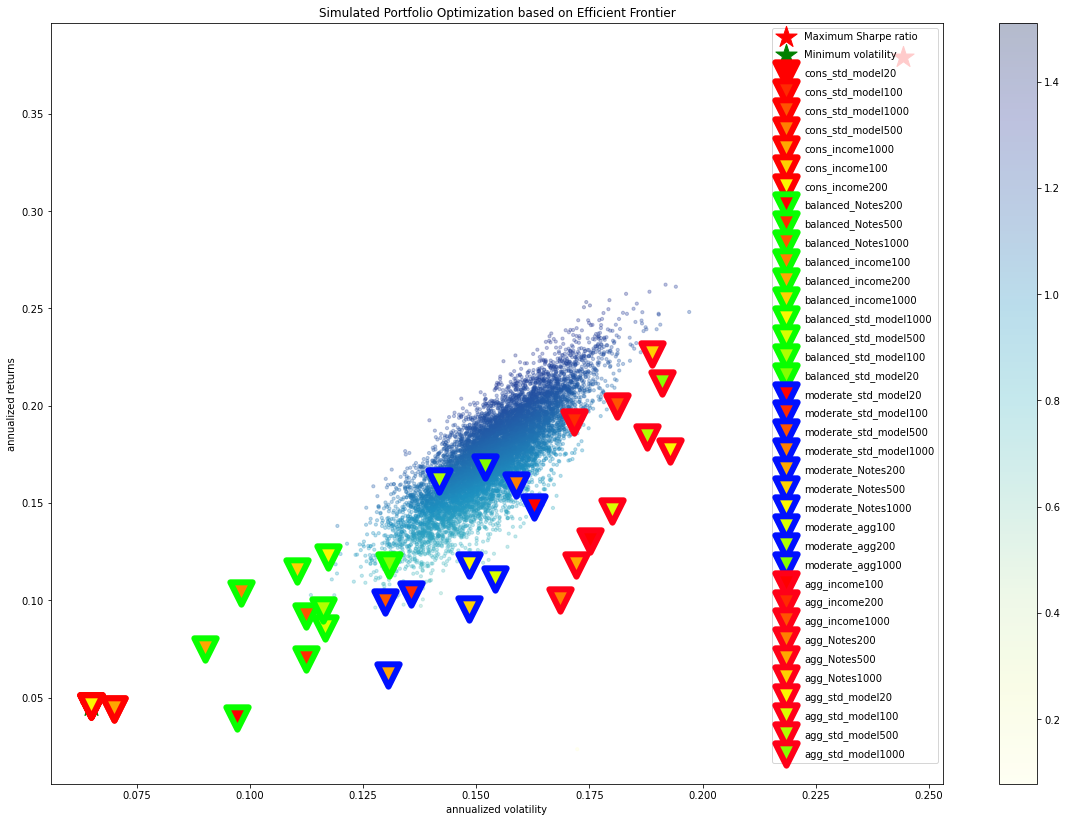

In [25]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, random_portfolios, model_portfolios)

What do we see? \
~ A linear model. This is because bonds did not negatively correlate with stocks as expected -- instead of the typical negative association, they are more positively correlated than would be expected
~ Dominant portfolios. The most aggressive portfolio happened to have the highest risk-returns ratio. The least aggressive portfolio happened to have the lowest risk-return ratio.

Efficient Frontier with best fit line:

In [26]:
def random_portfolios_linear_combo(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios+100))
    weights_record = []
    for i in range(num_portfolios + 100):
        if i < 100:
            weights = np.atleast_2d(np.zeros((len(mean_returns)))).T
            op_weight = (100-i)/100
            weights[5,0] = op_weight
            weights[0,0] = 1-op_weight
        elif i  >= 100 and i < len(mean_returns) + 100:
            weights = np.atleast_2d(np.zeros((len(mean_returns)))).T
            weights[i-100,0] = 1
        else:
            weights = np.atleast_2d(np.random.random(len(mean_returns))).T
            weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.38
Annualized Volatility: 0.24


            CapPres  Balanced  ProGrowth  AggressiveGrowth  DividendEquity  \
allocation      0.0       0.0        0.0               0.0             0.0   

            OppEquity  Notes  Defined  
allocation      100.0    0.0      0.0  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 0.05
Annualized Volatility: 0.06


            CapPres  Balanced  ProGrowth  AggressiveGrowth  DividendEquity  \
allocation    100.0       0.0        0.0               0.0             0.0   

            OppEquity  Notes  Defined  
allocation        0.0    0.0      0.0  


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

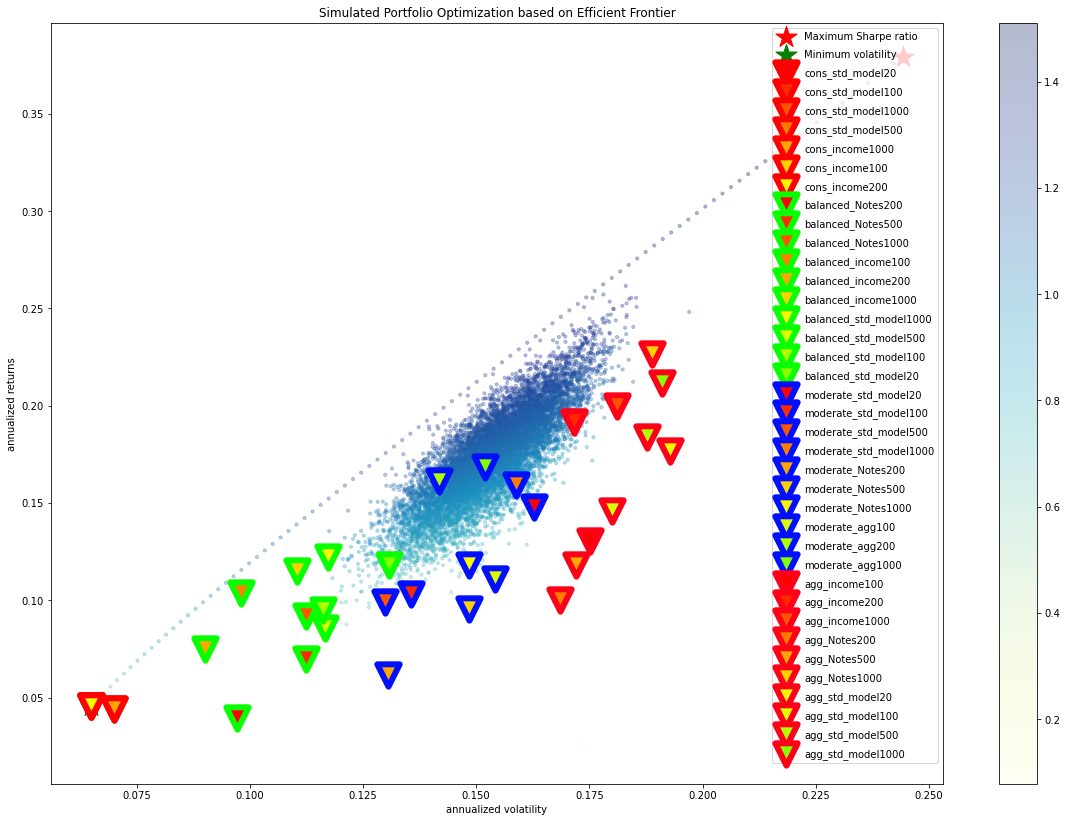

In [27]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, random_portfolios_linear_combo, model_portfolios)

Efficient Frontier WITHOUT Opportunistic Equity

In [28]:
def random_portfolios_ex_op(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios+100))
    weights_record = []
    for i in range(num_portfolios + 100):
        if i < 100:
            weights = np.atleast_2d(np.zeros((len(mean_returns)))).T
            op_weight = 0
            weights[5,0] = op_weight
            weights[0,0] = 1-op_weight
        elif i  >= 100 and i < len(mean_returns) + 100:
            if i-100 == 5:
                continue
            weights = np.atleast_2d(np.zeros((len(mean_returns)))).T
            weights[i-100,0] = 1
        else:
            weights = np.atleast_2d(np.random.random(len(mean_returns))).T
            weights[5,0] = 0
            weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.25
Annualized Volatility: 0.17


            CapPres  Balanced  ProGrowth  AggressiveGrowth  DividendEquity  \
allocation      0.0       0.0        0.0               0.0           100.0   

            OppEquity  Notes  Defined  
allocation        0.0    0.0      0.0  
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 0.0
Annualized Volatility: 0.0


            CapPres  Balanced  ProGrowth  AggressiveGrowth  DividendEquity  \
allocation      0.0       0.0        0.0               0.0             0.0   

            OppEquity  Notes  Defined  
allocation        0.0  100.0      0.0  


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

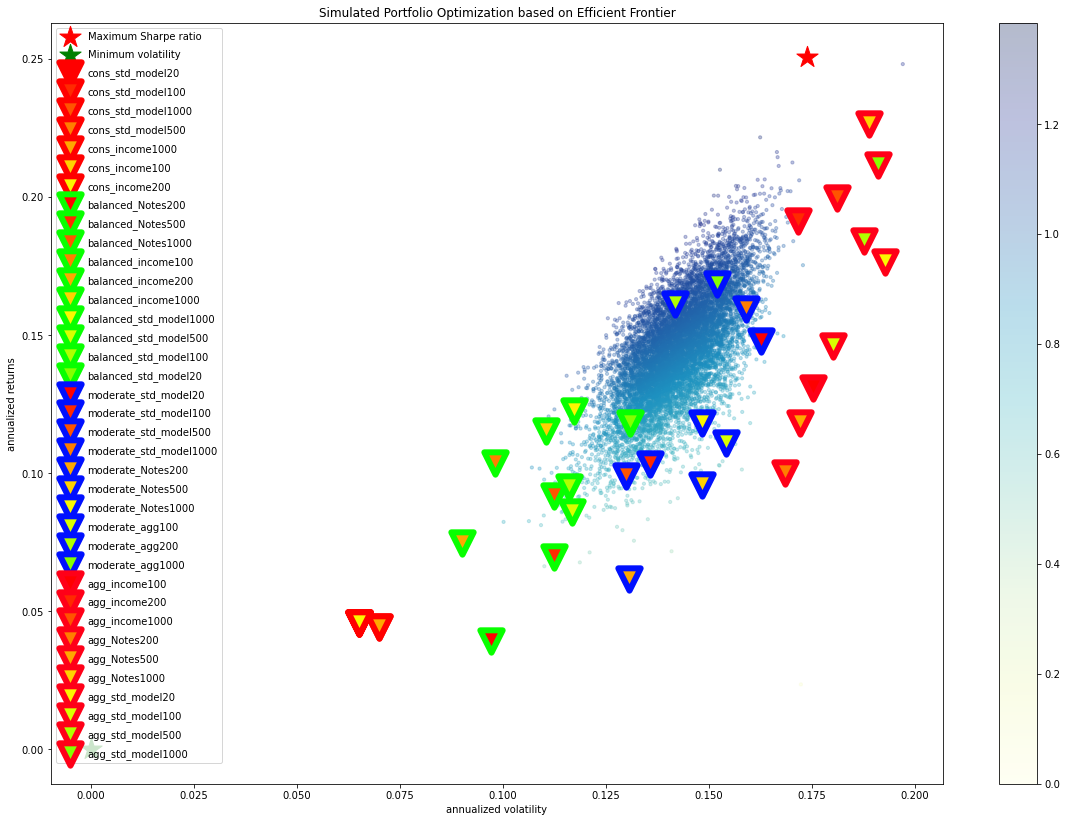

In [29]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate, random_portfolios_ex_op, model_portfolios)

CALCULATING RISK/RETURN RATIOS FOR EACH RISK GROUP

In [30]:
asset_sharpe=pd.DataFrame(index=agg_list, columns=['AggressiveGrowth', 'OppEquity', 'DividendEquity', 'Notes', "Defined"],
                     data=[[.7,0,0,.3,0],
                          [.5,0,.4,.1,0],
                          [.7,0,.3,0,0],
                          [.5,0,0,.5,0],
                          [.4,.1,0,.5,0],
                          [.5,.1,0,0,.4],
                          [1,0,0,0,0],
                           [.8,0,0,.2,0],
                           [.6,.2,0,.2,0],
                           [.7,.1,0,0,.2]])

In [31]:
underlying_ports.loc[:,'Return'] = mean_returns
underlying_ports.loc[:, 'Vol'] = vol
underlying_ports.loc[:,'Sharpe'] = underlying_ports.loc[:,'Return']/underlying_ports.loc[:, 'Vol']

underlying_ports

,Return,Vol,Sharpe
CapPres,0.045623,0.064946,0.702481
Balanced,0.118239,0.130728,0.904462
ProGrowth,0.147691,0.162715,0.907666
AggressiveGrowth,0.176450,0.192797,0.915211
DividendEquity,0.250589,0.173802,1.441811
OppEquity,0.378991,0.244230,1.551782
Notes,0.023466,0.172311,0.136184
Defined,0.248149,0.197049,1.259327


In [54]:
#aggressive portfolio allocations of underlying assets
agg_allo=pd.DataFrame(index=agg_list, columns=['AggressiveGrowth', 'OppEquity', 'DividendEquity', 'Notes', "Defined"],
                     data=[[.7,0,0,.3,0],
                          [.5,0,.4,.1,0],
                          [.7,0,.3,0,0],
                          [.5,0,0,.5,0],
                          [.4,.1,0,.5,0],
                          [.5,.1,0,0,.4],
                          [1,0,0,0,0],
                           [.8,0,0,.2,0],
                           [.6,.2,0,.2,0],
                           [.7,.1,0,0,.2]])
pd.concat([agg_allo, model_portfolios.mean_variance.loc[agg_allo.index, :'Sharpe']], axis=1).sort_values('Sharpe')

#moderately aggressive portfolio allocations of underlying assets
moderate_agg_allo=pd.DataFrame(index=moderate_agg_list, columns=['ProGrowth', 'OppEquity','CapPres', 'Notes', "Defined", "Balanced", "Dividend Equity"],
                     data=[[1,0,0,0,0,0,0],
                          [.6,0,.2,.2,0,0,0],
                          [.6,.1,.1,.2,0,0,0],
                          [.8,.1,.1,0,0,0,0],
                          [.25,0,.25,.5,0,0,0],
                          [0,.1,0,.5,0,.4,0],
                           [0,.1,0,.4,0,.4,0],
                          [.7,0,0,.3,0,0,0],
                           [0,0,0,.1,0,.5,.4],
                           [.6,0,.1,0,.2,0, .1]])
pd.concat([moderate_agg_allo, model_portfolios.mean_variance.loc[moderate_agg_allo.index, :'Sharpe']], axis=1).sort_values('Sharpe')


# model_returns.loc[:,'moderate_std_model20'] = model_returns["ProGrowth"]
# model_returns.loc[:,'moderate_std_model100'] = model_returns['CapPres']*.20 + model_returns["ProGrowth"]*.60 + model_returns['Notes']*.20
# model_returns.loc[:,'moderate_std_model500'] = model_returns['CapPres']*.10 + model_returns["ProGrowth"]*.60 + model_returns['Notes']*.20
# + model_returns["OppEquity"]*.10
# model_returns.loc[:,'moderate_std_model1000'] = model_returns['CapPres']*.10 + model_returns['ProGrowth']*.80 + model_returns["OppEquity"]*.10
# model_returns.loc[:,'moderate_Notes200'] = model_returns['CapPres']*.25 + model_returns['ProGrowth']*.25 + model_returns["Notes"]*.50
# model_returns.loc[:,'moderate_Notes500'] = model_returns['Balanced']*.40 + model_returns['Notes']*.50 + model_returns['OppEquity']*.10
# model_returns.loc[:,'moderate_Notes1000'] = model_returns['Balanced']*.40 + model_returns['Notes']*.40 + model_returns["OppEquity"]*.10 + model_returns["Defined"]*.10
# model_returns.loc[:,"moderate_agg100"] = model_returns["ProGrowth"]*.70 + model_returns["Notes"]*.3
# model_returns.loc[:,'moderate_agg200'] = model_returns['Balanced']*.50 + model_returns['Notes']*.10 + model_returns['DividendEquity']*.40
# model_returns.loc[:,'moderate_agg1000'] = model_returns['CapPres']*.10 + model_returns['ProGrowth']*.60 + model_returns['DividendEquity']*.10 + model_returns["Defined"]*.20

# moderate_agg_list = ['moderate_std_model20','moderate_std_model100','moderate_std_model500','moderate_std_model1000','moderate_Notes200',
#                      'moderate_Notes500','moderate_Notes1000','moderate_agg100','moderate_agg200','moderate_agg1000']
#balanced portfolio allocations of underlying assets
# balanced_allo=pd.DataFrame(index=balanced_list, columns=['CapPres', 'Notes', "OppEquity", "Defined", "Balanced", "Dividend Equity"],
#                      data=[[.6,.4,0,0,0,0],
#                           [.5,.4,.10,0,0,0],
#                           [.5,.1,.1,.3,0,0],
#                           [.6,.1,0,0,0,.3],
#                           [.6,0,0,0,.4,0],
#                           [.4,0,0,.2,.4,0],
#                            [.3,0,0,.2,0,.5,],
#                           [.2,.2,0,0,.6,0],
#                            [.2,.1,0,0,.7,0],
#                            [0,0,0,0,1,0]])
# pd.concat([balanced_allo, model_portfolios.mean_variance.loc[balanced_allo.index, :'Sharpe']], axis=1).sort_values('Sharpe')

#balancedportfolio allocations of underlying assets
# conservative_allo=pd.DataFrame(index=cons_list, columns=['CapPres', 'Notes'],
#                      data=[[1,0],
#                           [1,0],
#                           [.9,.10],
#                           [1,0],
#                            [.9,.10],
#                             [1,0],
#                             [1,0]
#                             ])
# pd.concat([conservative_allo, model_portfolios.mean_variance.loc[cons_list, :'Sharpe']], axis=1)



# model_returns.loc[:,'cons_std_model20'] = model_returns.loc[:,"CapPres"]
# model_returns.loc[:,'cons_std_model100'] = model_returns["CapPres"]
# model_returns.loc[:,'cons_std_model1000'] = model_returns['CapPres']*.90 + model_returns['Notes']*.10
# model_returns.loc[:,"cons_std_model500"] = model_returns["CapPres"]
# model_returns.loc[:,'cons_income100'] = model_returns['CapPres']
# model_returns.loc[:,'cons_income200'] = model_returns['CapPres']
# model_returns.loc[:,"cons_income1000"] = model_returns["CapPres"]*.90 + model_returns['Notes']*.10
# #cons_list = ["cons_std_model20", "cons_std_model100", "cons_std_model1000", 'cons_std_model500', "cons_income1000", 'cons_income100', 'cons_income200']

#model_portfolios.ports['Conservative'].mean_variance.loc[cons_list]


,ProGrowth,OppEquity,CapPres,Notes,Defined,Balanced,Dividend Equity,Annualized Returns,Standard Deviation,Sharpe
moderate_Notes200,0.25,0.0,0.25,0.5,0.0,0.0,0.0,0.061766,0.130538,0.473166
moderate_Notes500,0.00,0.1,0.00,0.5,0.0,0.4,0.0,0.095555,0.148377,0.643998
moderate_agg100,0.70,0.0,0.00,0.3,0.0,0.0,0.0,0.110955,0.154195,0.719576
moderate_std_model100,0.60,0.0,0.20,0.2,0.0,0.0,0.0,0.103356,0.135626,0.762067
moderate_std_model500,0.60,0.1,0.10,0.2,0.0,0.0,0.0,0.099073,0.12976,0.763515
moderate_Notes1000,0.00,0.1,0.00,0.4,0.0,0.4,0.0,0.118038,0.148314,0.795866
moderate_std_model20,1.00,0.0,0.00,0.0,0.0,0.0,0.0,0.147691,0.162715,0.907666
moderate_std_model1000,0.80,0.1,0.10,0.0,0.0,0.0,0.0,0.159476,0.158885,1.003722
moderate_agg1000,0.60,0.0,0.10,0.0,0.2,0.0,0.1,0.168608,0.15197,1.109479
moderate_agg200,0.00,0.0,0.00,0.1,0.0,0.5,0.4,0.161123,0.141835,1.135986


In [33]:
underlying_ports['expected_returns'] = [0.05, 0.07,.08,.09,.09,0.09,0.09,0.08]

In [34]:
expected_ret = np.atleast_2d([0.05, 0.07,.08,.09,.09,0.09,0.09,0.08])

In [35]:
cov_matrix

array([[1.67378371e-05, 3.19105860e-05, 3.86010193e-05, 4.43000691e-05,
        3.53437933e-05, 5.22069414e-05, 2.60869921e-05, 3.52814181e-05],
       [3.19105860e-05, 6.78171043e-05, 8.40884588e-05, 9.85982018e-05,
        7.70889254e-05, 1.15890575e-04, 6.02617950e-05, 8.02092046e-05],
       [3.86010193e-05, 8.40884588e-05, 1.05064313e-04, 1.24006669e-04,
        9.53225529e-05, 1.44875907e-04, 7.68193346e-05, 1.01512514e-04],
       [4.43000691e-05, 9.85982018e-05, 1.24006669e-04, 1.47502542e-04,
        1.12082862e-04, 1.71973568e-04, 9.24957340e-05, 1.21641837e-04],
       [3.53437933e-05, 7.70889254e-05, 9.53225529e-05, 1.12082862e-04,
        1.19869217e-04, 1.47812397e-04, 7.07093195e-05, 9.35510150e-05],
       [5.22069414e-05, 1.15890575e-04, 1.44875907e-04, 1.71973568e-04,
        1.47812397e-04, 2.36699155e-04, 1.13151704e-04, 1.48254106e-04],
       [2.60869921e-05, 6.02617950e-05, 7.68193346e-05, 9.24957340e-05,
        7.07093195e-05, 1.13151704e-04, 1.17821282e-04, 8.

<H2>Analysis</H2>

Aggressive: The portfolios in the "aggressive" risk group largely fall into an annualized volatility range of 17.5% to 20%. The following portfolios demonstrate low risk/return ratios: "agg_Notes200, agg_Notes500, agg_income100 and agg_std_model100. The dataframe below demonstrates that these 4 outliers all contain a high percentage of Notes. While the realized returns in Notes are likely below their long-run performance expectations, Notes are known for risk inefficiency which is confirmed by the data, albeit, in a likely exaggerated manner.

An effective alternative to Notes are the Defined Investment Fund (DIA). The agg_std_model1000 and the agg_Notes1000 models, which yield the two highest Sharp ratios, contain 20% and 40% DIA respectively with high percentages of Aggressive growth. 


Moderately Aggressive: The portfolios in the "moderately aggressive" risk group largely fall into an annualized volatility range of 12.5% to 17.5%. The moderate_Notes200 and moderate_Notes500 portfolios demonstrate the lowest Risk/Return ratios, followed by moderate_agg100, moderate_std_model100, and moderate_std_model500. Similar to the Aggressive risk class, the data below demonstrates that the 5 portfolios with the lowest Sharpe ratio contain a higher percentage of Notes than the other portfolios, EXCEPT for the moderate_std_model1000, which makes up for it's high percentage of low performing Notes with a 25%-25% combination of ProGrowth and CapPres.

The portfolios with the highest risk/return ratios in the Moderately Aggressive group are moderate_agg1000, moderate_agg200, and moderate_std_model1000. These three portfolios contain a high percentage of either ProGrowth or DividendEquity.

Maximizing the risk/return ratio of each portfolio is the goal -- and we are already beginning to see the underlying stocks that help us do that. Similar to the Aggressive group, a combination of Defined, OppEquity, and DividendEquity should be allocated in every moderately aggressive portfolio, but to a lesser extent that it is allocated to an aggressive portfolio. We'll get into the allocation details later.



Balanced: The portfolios in the "moderately aggressive" risk group largely fall into an annualized volatility range of 5% to 15%. The balanced_Notes200 and balanced_Notes500 yield the lowest Risk/Return ratios, followed by balanced_std_model500 and balanced_std_model100. The lowest scoring Sharpe ratio portfolios in the balanced risk group also contain comparitively high percentages of Notes.

The portfolios with the highest risk/return ratios are the balanced_std_model1000 and the balanced_income100 models. These three portfolios contain a high percentage of either CapPres or DividendEquity.


Conservative: The portfolios in the "conservative" risk group largely fall into an annualized volatility range of 0% to 7.5%. The allocation of each portfolio in the conservative group has little to no variation, with CapPres and Notes being the only two assets that make up the entire group. Cons_std_model1000 and cons_income200	yield the lowest risk/returns ratio of 0.65. Again, these are the two models that containa small percentage of notes.

OPTIMIZATION

In [36]:
def vol_function(weights):
    weights = np.atleast_2d(weights)
    return np.sqrt(np.dot(weights, np.dot(cov_matrix, weights.T)))*np.sqrt(252)
def returns(weights):
    weights = np.atleast_2d(weights)
    return -np.matmul(weights, expected_ret.T)
def eq_func(weights):
    return [sum(weights)]
def in_eq_func(weights):
    return weights + [vol_function(weights)]

In [37]:
expected_ret.shape 

(1, 8)

In [38]:
np.atleast_2d([0,0,0,1,0,0,0,0, .19][:-1]).shape



(1, 8)

In [39]:
returns([0,0,0,1,0,0,0,0, .19])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 8 is different from 9)

In [ ]:
starting_point=[0,0,0,1,0,0,0,0]
inequality_lower_bounds = [0, 0, 0, 0, 0,0,0,0, .18]
inequality_upper_bounds = [1, 1, 1,1,1,1,1,1, .24]

def solve():
    resultagg = pysolnp.solve(
        obj_func=returns,
        par_start_value=starting_point,
        ineq_func=in_eq_func,
        ineq_lower_bounds=inequality_lower_bounds,
        ineq_upper_bounds=inequality_upper_bounds,
        eq_func = eq_func,
        eq_values =[1])
    return resultagg
resultagg = solve()

In [ ]:
opt_results_agg = resultagg.optimum
agg_rounded = (lambda x:  ["%.2f"  % elem for elem  in x])(opt_results_agg)
agg_rounded

In [ ]:
starting_point=[0,0,0,1,0,0,0,0]
inequality_lower_bounds = [0, 0, 0, 0, 0,0,0,0, .12]
inequality_upper_bounds = [1, 1, 1,1,1,1,1,1, .18]

def solve():
    resultmod = pysolnp.solve(
        obj_func=returns,
        par_start_value=starting_point,
        ineq_func=in_eq_func,
        ineq_lower_bounds=inequality_lower_bounds,
        ineq_upper_bounds=inequality_upper_bounds,
        eq_func = eq_func,
        eq_values =[1])
    return resultmod
resultmod = solve()


In [ ]:
opt_results_mod_agg = resultmod.optimum
mod_agg_rounded = (lambda x:  ["%.2f"  % elem for elem  in x])(opt_results_mod_agg)
mod_agg_rounded

In [ ]:
starting_point=[0,0,0,1,0,0,0,0]
inequality_lower_bounds = [0, 0, 0, 0, 0,0,0,0, .08]
inequality_upper_bounds = [1, 1, 1,1,1,1,1,1, .12]

def solve():
    resultbal = pysolnp.solve(
        obj_func=returns,
        par_start_value=starting_point,
        ineq_func=in_eq_func,
        ineq_lower_bounds=inequality_lower_bounds,
        ineq_upper_bounds=inequality_upper_bounds,
        eq_func = eq_func,
        eq_values =[1])
    return resultbal
resultbal = solve()


In [ ]:
opt_results_balanced = resultbal.optimum
balanced_rounded = (lambda x:  ["%.2f"  % elem for elem  in x])(opt_results_balanced)
balanced_rounded

In [ ]:
starting_point=[0,0,0,1,0,0,0,0]
inequality_lower_bounds = [0, 0, 0, 0, 0,0,0,0, 0]
inequality_upper_bounds = [1, 1, 1,1,1,1,1,1, .8]

def solve():
    resultcons = pysolnp.solve(
        obj_func=returns,
        par_start_value=starting_point,
        ineq_func=in_eq_func,
        ineq_lower_bounds=inequality_lower_bounds,
        ineq_upper_bounds=inequality_upper_bounds,
        eq_func = eq_func,
        eq_values =[1])
    return resultcons
resultcons = solve()


In [ ]:
opt_results_conservative = resultcons.optimum

cons_rounded = (lambda x:  ["%.2f"  % elem for elem  in x])(opt_results_conservative)
cons_rounded

<H2>Optimization Results</H2>

Given this information, reallocation according to the following dataframe would increase our returns significantly:

~ the volatility demonstrated in this time period is fairly reasonable.
~ Expected long-term returns: In the long run, stocks perform about 9% a year, bonds about 4%.

In [ ]:
import pandas as pd

new_allo_df = pd.DataFrame(data = [cons_rounded, balanced_rounded, mod_agg_rounded, agg_rounded], columns = model_returns.columns[0:8])
new_allo_df.index = ["Conservative", "Balanced","Moderately Aggressive", "Aggressive"]
new_allo_df  


In [ ]:
models_w_sharpe_df = model_portfolios.mean_variance

In [ ]:
models_w_sharpe_df.to_csv("models_w_sharpe_df.csv")

Conclusion: Across the board, Notes performed poorly given their amount of risk. We must be skeptical about these results, however, as Notes do not always perform so poorly. Looking forward, we expect that Notes will perform better than they have in the past, although their recurring negative results give us reason to be cautious and limited in their use.